In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Tensorflow & Keras
import os
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

Found 14330 images belonging to 5 classes.
Found 320 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


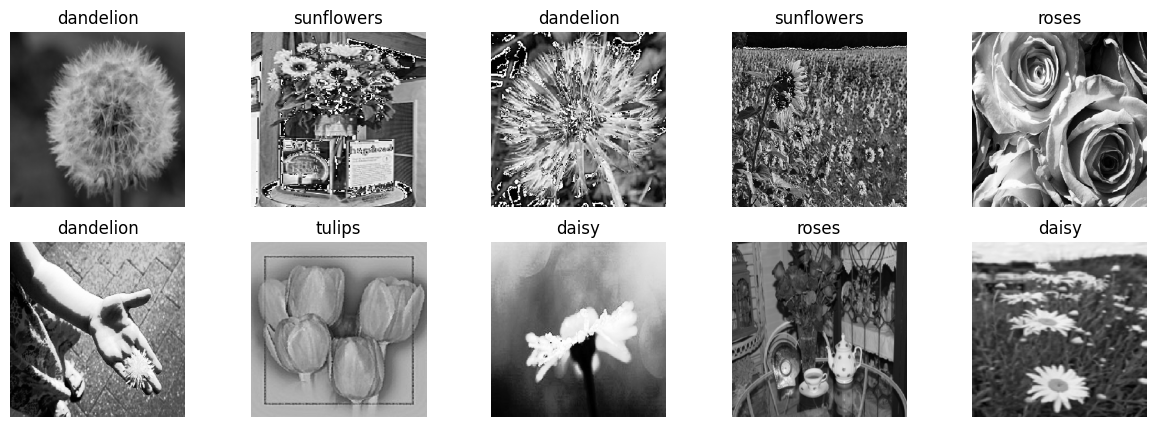

In [3]:

# Define paths to your data
base_dir = "/content/drive/MyDrive/Flower_Identification/processed_flower_dataset"  # Change this to your base directory
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Data preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Assuming your images are of size 299x299 for Xception
img_size = (299, 299)

# Create data generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # To keep the order of predictions
)

# Create a dictionary mapping class indices to class labels
class_labels = {v: k for k, v in train_generator.class_indices.items()}

# Visualize a few training samples
plt.figure(figsize=(15, 5))
batch_size = 10  # Adjust this based on the number of samples you want to visualize

for i in range(batch_size):
    img, label = train_generator.next()
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[0])

    # Get the class label from the dictionary
    class_label = class_labels[np.argmax(label[0])]

    plt.title(class_label)
    plt.axis('off')

plt.show()

# ... Rest of the code remains the same for model creation and training


In [4]:
# Normalize pixel values to be between 0 and 1
train_images, train_labels = train_generator.next()
train_images = train_images.astype('float32') / 255.0

validation_images, validation_labels = validation_generator.next()
validation_images = validation_images.astype('float32') / 255.0

In [5]:
# Assuming you have a test generator
test_generator = datagen.flow_from_directory(
    test_dir,  # Use test_dir instead of data_dir
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # To keep the order of predictions
)

# One-hot encoded labels are directly accessible from the generator
train_labels = train_generator.classes
test_labels = test_generator.classes

Found 200 images belonging to 5 classes.


In [6]:
import tensorflow as tf
from keras.layers import Input, Dense, GlobalAveragePooling2D, Reshape, multiply
from keras.models import Model
from keras.applications import ResNet50
from keras.layers import BatchNormalization, Activation, Conv2D, AveragePooling2D, Flatten

def se_block(x, ratio=16):
    channels = tf.keras.backend.int_shape(x)[-1]

    squeezed = GlobalAveragePooling2D()(x)
    excitation = Dense(channels // ratio, activation='relu')(squeezed)
    excitation = Dense(channels, activation='sigmoid')(excitation)

    excitation = Reshape((1, 1, channels))(excitation)
    scaled = multiply([x, excitation])

    return scaled

def create_senet(include_top, initial_conv_filters, pooling, classes):

    img_input = Input(shape=(299, 299, 3))

    # Initial Convolution Layer
    x = Conv2D(initial_conv_filters, (7, 7), padding='same', use_bias=False, strides=(2, 2), kernel_initializer='he_normal')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # SENet Blocks
    x = se_block(x)
    x = AveragePooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Add more SENet blocks or modify structure based on your requirements

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=img_input, outputs=x)

    return model

# Assuming you have the necessary parameters
# Assuming you have the necessary parameters
NUM_CLASSES = 5  # Replace 5 with the actual number of classes in your problem
model = create_senet(include_top=True, initial_conv_filters=64, pooling='avg', classes=NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 150, 150, 64)         9408      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 150, 150, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 150, 150, 64)         0         ['batch_normalization[0][0

In [7]:
# Train the SENet model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/10
447/447 [==============================] - 3069s 7s/step - loss: 1.5787 - accuracy: 0.2748 - val_loss: 1.6165 - val_accuracy: 0.2562
Epoch 2/10
447/447 [==============================] - 84s 188ms/step - loss: 1.5610 - accuracy: 0.3042 - val_loss: 1.5912 - val_accuracy: 0.2594
Epoch 3/10
447/447 [==============================] - 83s 186ms/step - loss: 1.5493 - accuracy: 0.3204 - val_loss: 1.5892 - val_accuracy: 0.2344
Epoch 4/10
447/447 [==============================] - 81s 181ms/step - loss: 1.5391 - accuracy: 0.3242 - val_loss: 1.5463 - val_accuracy: 0.2688
Epoch 5/10
447/447 [==============================] - 84s 187ms/step - loss: 1.5261 - accuracy: 0.3363 - val_loss: 1.8326 - val_accuracy: 0.2062
Epoch 6/10
447/447 [==============================] - 84s 188ms/step - loss: 1.5161 - accuracy: 0.3475 - val_loss: 1.5185 - val_accuracy: 0.3250
Epoch 7/10
447/447 [==============================] - 82s 184ms/step - loss: 1.5077 - accuracy: 0.3535 - val_loss: 1.6643 - val_acc

In [8]:
from sklearn.metrics import classification_report
import numpy as np
test_generator.reset()
# Generate predictions
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


7/7 [==============================] - 43s 7s/step
Classification Report:
              precision    recall  f1-score   support

       daisy       0.71      0.12      0.21        40
   dandelion       0.25      0.95      0.39        40
       roses       0.67      0.05      0.09        40
  sunflowers       0.20      0.07      0.11        40
      tulips       0.59      0.33      0.42        40

    accuracy                           0.30       200
   macro avg       0.48      0.30      0.25       200
weighted avg       0.48      0.30      0.25       200



7/7 [==============================] - 2s 250ms/step


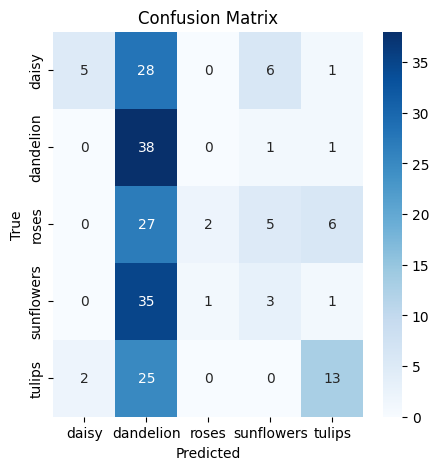

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
test_generator.reset()
# Generate predictions
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(len(class_labels), len(class_labels)))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
